# Imports

In [4]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os 
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Defining the path for test and train data

In [5]:
import splitfolders

input_folder = '/kaggle/input/v2-plant-seedlings-dataset'
output_folder = '/kaggle/dataset'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .0, .2))

Copying files: 5539 files [01:39, 55.84 files/s] 


In [9]:
import glob

train_length = 0
test_length = 0

for name in glob.glob('/kaggle/dataset/train/*'):
  train_length += len(glob.glob(name+'/*.png'))

for name in glob.glob('/kaggle/dataset/test/*'):
  test_length += len(glob.glob(name+'/*.png'))

print(train_length,test_length)

4426 1113


# Creating the dataset

In [10]:
batch_size = 32
img_height = 120
img_width = 120

In [11]:
data_dir_train = '/kaggle/dataset/train'
data_dir_test = '/kaggle/dataset/test'

In [12]:
# creating train dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="training", seed=123,
                                                               image_size=(img_height, img_width), batch_size=batch_size)

Found 4426 files belonging to 13 classes.
Using 3541 files for training.


In [13]:
# creating validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, validation_split=0.2, subset="validation", seed=123,
                                                             image_size=(img_height, img_width), batch_size=batch_size)

Found 4426 files belonging to 13 classes.
Using 885 files for validation.


In [14]:
# Listing out all the classes of plant seedlings and store them in a list.

labels = sorted(os.listdir(data_dir_train))
print(labels)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherd’s Purse', 'Small-flowered Cranesbill', 'Sugar beet', 'nonsegmentedv2']


In [15]:
# creating a list which counts the number of images in each class of plant seedling
count_plot = []
for i in labels:
    count_plot.append(len(os.listdir(os.path.join(data_dir_train,i))))

In [16]:
count_plot

[247, 361, 268, 570, 202, 430, 609, 205, 485, 219, 460, 370, 0]

# Visualizing the data

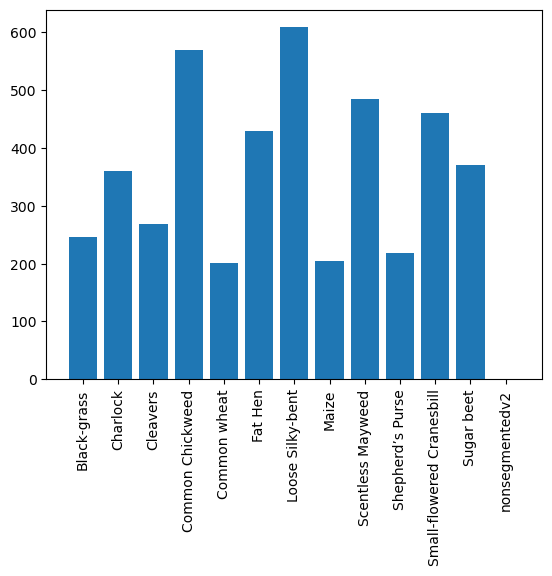

In [17]:
# creating plot for distribution of images in each class
count_plot = np.array(count_plot)
plt.bar(labels, count_plot)
plt.xticks(rotation = 90)
plt.show()

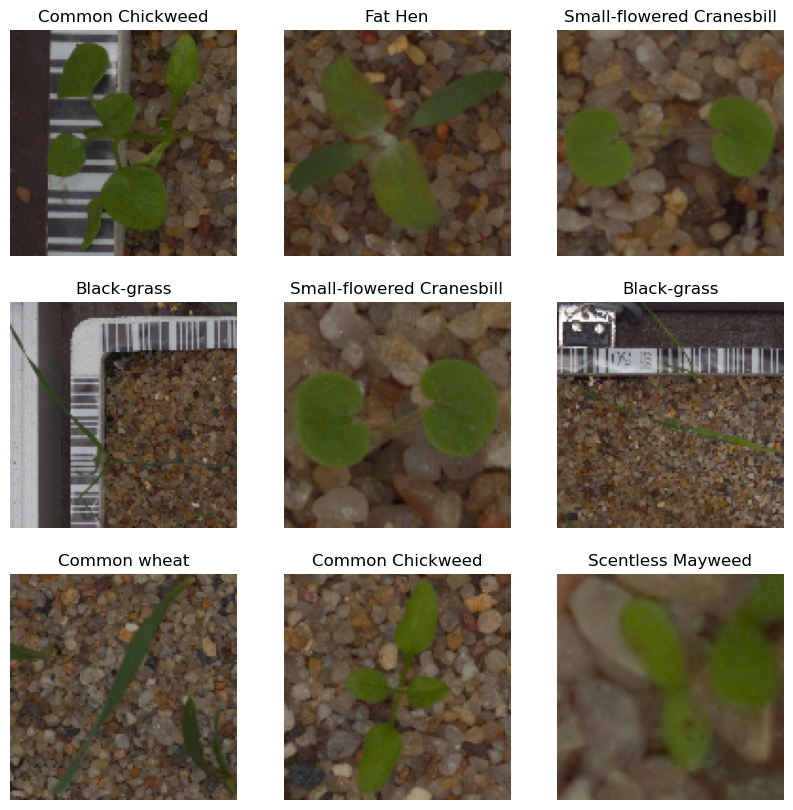

In [18]:
# visualizing few images from the train data
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for image, label in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    plt.title(labels[label[i]])
    plt.axis("off")

# Creating a Model 

In [19]:
### defining the path for training and test images
train_path = "/kaggle/dataset/train/"
test_path = "/kaggle/dataset/test/"

In [20]:
### distibution of classes for each category of data
### It can be seen that data has imbalances in the class distribution
for i in labels:
    directory =train_path + i + '/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.png')))
    print(f'{i} has {length} samples.')

Black-grass has 247 samples.
Charlock has 361 samples.
Cleavers has 268 samples.
Common Chickweed has 570 samples.
Common wheat has 202 samples.
Fat Hen has 430 samples.
Loose Silky-bent has 609 samples.
Maize has 205 samples.
Scentless Mayweed has 485 samples.
Shepherd’s Purse has 219 samples.
Small-flowered Cranesbill has 460 samples.
Sugar beet has 370 samples.
nonsegmentedv2 has 0 samples.


In [21]:
# Augmentor is used to add more samples across all classes
!pip install Augmentor

In [22]:
path_to_training_dataset=train_path

import Augmentor
for i in labels:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 247 image(s) found.
Output directory set to /kaggle/dataset/train/Black-grass/output.

Processing <PIL.Image.Image image mode=RGB size=641x641 at 0x7F43C4F178B0>: 100%|██████████| 500/500 [02:01<00:00,  4.13 Samples/s]                  


Initialised with 361 image(s) found.
Output directory set to /kaggle/dataset/train/Charlock/output.

Processing <PIL.Image.Image image mode=RGB size=281x281 at 0x7F43A067C280>:  62%|██████▏   | 309/500 [00:39<00:24,  7.80 Samples/s]                  


KeyboardInterrupt: 

In [ ]:
### Distribution of classes after augmentation
for i in labels:
    directory =train_path+i+'/'
    directory_out =train_path+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.png')))
    length_out=len(list(class_directory_out.glob('*.png')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

In [ ]:
batch_size = 32
img_height = 120
img_width = 120

In [ ]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
input_shape = (120,120,3)
num_classes = 12

model4 = Sequential()
model4.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset=0.0))
model4.add(Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(32, kernel_size=(3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(64, (3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(128, (3, 3)))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.10))

model4.add(Flatten())
model4.add(Dense(256))
model4.add(Activation('relu'))
model4.add(Dropout(0.25))
model4.add(Dense(num_classes))
model4.add(Activation('softmax'))

In [ ]:
### choosing an appropirate optimiser and loss function
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# spefying the format in which model needs to be saved
model_name = 'Seed4' + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)
 # giving the file path
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{val_loss:.5f}-.h5'
# Creating the call back for saving only the best models
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=5, verbose=1, mode='max', min_lr=1e-5)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# creating the callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

callbacks_list = [checkpoint, early_stopping, lr_reduce]

In [ ]:
### training the model
epochs = 100
batch_size = 32
history = model4.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list)

In [ ]:
### visualizing the model results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(14)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()